In [1]:
import os
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import xarray as xr
import rioxarray as rio

## Basin

In [2]:
# Read Basin
basin = gpd.read_file("C:/EAGLE/internship_job/Hiwi/DLR/test_xarray/input/aoi_sub.geojson")

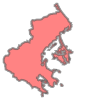

In [3]:
basin['geometry'][1]

In [4]:
# Calc area of all polygons in the geom
geom = basin['geometry'][1]
area = [geom[k].area for k in range(len(geom))]
area

[9.461165709830293e-05,
 2.425090311936935e-05,
 3.854922470317158e-05,
 0.00011328311859839473,
 2.530441702289884e-05,
 2.4250907791721548e-05,
 0.0001982101125092508,
 0.00018020365010167853,
 5.8993399777758914e-05,
 2.4250907874432553e-05,
 0.2096233307605664,
 0.0004734131908873624,
 0.000405137825130213,
 5.964854848295794e-05,
 2.6259883265813063e-05]

In [5]:
# Get the index of the largest polygon in geom
index = [i for i,k in enumerate(area) if k==max(area)]
# i is the index of k
index = index[0]
index

10

In [6]:
# Select the largest piece polygon and turn it into 'multipolygon' format
basin_main = basin['geometry'][1][index]
basin_main = MultiPolygon([basin_main])

<class 'shapely.geometry.polygon.Polygon'>


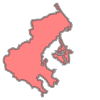

In [7]:
print(type(basin_main[0]))
basin_main[0]

## DEM

In [8]:
dem = rio.open_rasterio("C:/EAGLE/internship_job/Hiwi/DLR/test_xarray/input/SRTM_V4_90m_Vietnam_larger.tif", masked=True)

## Clip DEM by Basin

In [9]:
dem_clip = dem.rio.clip(basin_main)

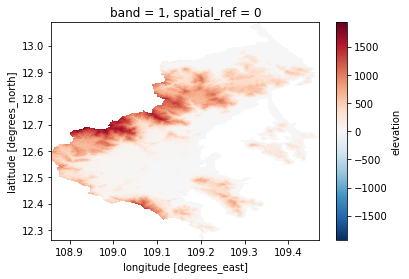

In [10]:
dem_clip.plot()

## Reproject DEM (raster)

In [11]:
dem_utm = dem_clip.rio.reproject(dem_clip.rio.estimate_utm_crs())
crs = dem_utm.rio.crs
crs

CRS.from_epsg(32649)

In [12]:
int(str(crs).split(":")[-1])

32649

## Assign the projection to Basin (vector)

In [13]:
ls_crs = np.empty(len(basin), dtype=int)
ls_crs[0] = int(str(crs).split(":")[-1])
ls_crs

array([     32649, 1094064012])

In [14]:
basin_utm = basin.to_crs(crs)
#basin_utm.crs

## Write Raster

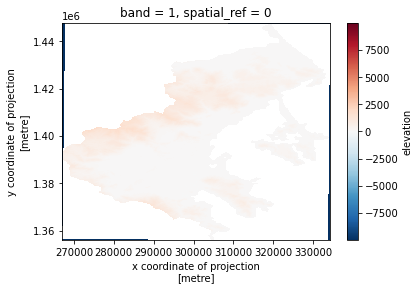

In [16]:
dem_utm.plot()

In [17]:
dem_utm.rio.to_raster("C:/EAGLE/internship_job/Hiwi/DLR/test_xarray/input/DEM_prj_clip.tif")

## Wrap-up

In [2]:
basin = "aoi_sub.geojson"
dem = "SRTM_V4_90m_Vietnam_larger.tif"
inpath = "C:/EAGLE/internship_job/Hiwi/DLR/test_xarray/input"
outpath = "C:/EAGLE/internship_job/Hiwi/DLR/test_xarray/input"

In [4]:
# Input DEM (Should be in WGS84)
dem_input = dem
path_dem = os.path.join(inpath, dem_input)
dem = rio.open_rasterio(path_dem, masked=True)

# Input Basin
basin_input = basin
path_basin = os.path.join(inpath, basin_input)
basin = gpd.read_file(path_basin)

In [47]:
###---------------------------Preprocessing--------------------------------------------------###

# Define a polygon and multi-polygon for 'if' statement
polygon = Polygon([[0, 0], [1, 0], [1, 1], [0, 1], [0, 0]])
multipolygon = MultiPolygon([polygon, polygon])

ls_crs = np.empty(len(basin))
for i in range(len(basin)):
    basin_geom = basin['geometry'][i]
    
    ###############################
    ### 1. Filter to Main Basin ###
    ###############################
    if type(basin_geom) == type(multipolygon):
        # Calc area of all polygons of the multipolygon
        area = [basin_geom[k].area for k in range(len(basin_geom))]

        # Get the index of the largest polygon
        index = [j for j,k in enumerate(area) if k==max(area)] # i is the index of k
        index = index[0]

        # Select the largest piece of polygon and turn it into 'multipolygon' format
        basin_main = MultiPolygon([basin_geom[index]])
        #basin_main = MultiPolygon([basin_main])
        
    elif type(basin_geom) == type(polygon):
        basin_main = MultiPolygon([basin_geom])
    
    
    ############################
    ### 2. Clip DEM by Basin ###
    ############################
    dem_clip = dem.rio.clip(basin_main)
    
    
    ########################
    ### 3. Reproject DEM ###
    ########################
    dem_prj = dem_clip.rio.reproject(dem_clip.rio.estimate_utm_crs())
    
    
    ##########################
    ### 4. Reproject Basin ###
    ##########################
    crs = dem_prj.rio.crs
    basin_prj = basin.to_crs(crs)
    
    ls_crs[i] = int(str(crs).split(":")[-1])
print(ls_crs)
    
    ############################
    ### 5. Export Masked DEM ###
    ############################
    # Copy Metadata of projected DEM before masking
    #out_meta = dem_prj.meta.copy()
    #out_meta.update({
    #    "driver": "GTiff",
    #    "count": dem_msk.shape[0],
    #    "height": dem_msk.shape[1],
    #    "width": dem_msk.shape[2],
    #    "transform": out_transform,
    #    "crs": dem_prj.crs
    #})
    # Export Masked DEM
    #path_dem_msk = os.path.join(outpath, dem_input.split(".")[0]+"_msk."+dem_input.split(".")[1])
    #with rasterio.open(path_dem_msk, "w", **out_meta) as dest:
    #    dest.write(dem_msk)
    #print("Export Masked DEM", i, "done!")
    
    
    ##############################
    ### 6. Load DEM into GRASS ###
    ##############################
    


[32648. 32649.]


In [ ]:
############################
### 4. Mask DEM by Basin ###
############################
def getFeatures(gdf):
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

basin_geom = getFeatures(basin[i:i+1])

# Load Projected DEM

# Mask DEM by Basin
dem_msk, out_transform = mask(dataset=dem, shapes=basin_geom, crop=True)

# Mask out NA
dem_msk = np.ma.masked_array(dem_msk, mask=(dem_msk < 0))
print("Mask DEM by Basin", i, "done!")
